In [1]:
import pytesseract, imutils, cv2, re, requests
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import numpy as np

### 이미지 전처리 함수

In [2]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [3]:
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
    image_list_title = []
    image_list = []
 
    org_image = image.copy()
    image = imutils.resize(image, width=width)
    ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
    findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
        if len(approx) == 4:
            findCnt = approx
            break
 
  # 만약 추출한 윤곽이 없을 경우 오류
    if findCnt is None:
        raise Exception(("Could not find outline."))
 
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
    image_list_title.append("Outline")
    image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform", transform_image)
 
    return transform_image

1. 그레이스케일로 변환.
2. 노이즈를 줄이기 위해 가우시안블러 적용.
3. 흐릿한 그레이스케일 이미지에 blackhat 모노폴리 연산을 적용(밝은 배경(명함의 배경)에서 어두운 영역(텍스트)을 드러내기 위해 사용)
4. 닫힘 연산을 통해 끊어져 보이는 객체를 연결하여 Grouping.

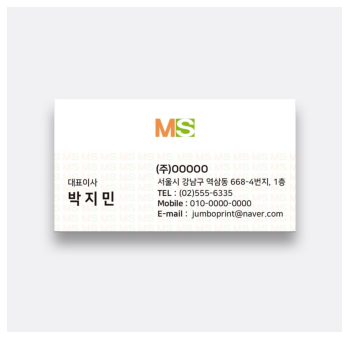

In [4]:
img_path = './bb.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 6)), plt.axis('off')
plt.imshow(img)

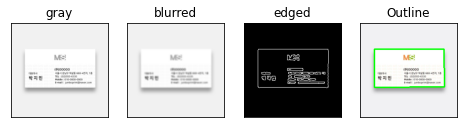

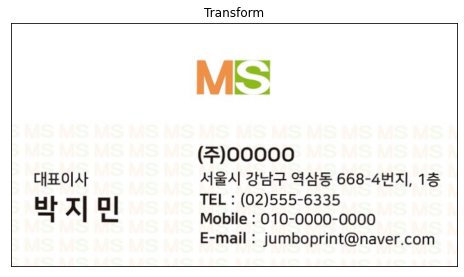

In [5]:
# img_path = './aa.jpg'
 
with open(img_path, 'rb') as f:
    data = f.read()
    
#encoded_img = np.fromstring(data, dtype = np.uint8)
encoded_img = np.frombuffer(data, dtype = np.uint8)
    
org_image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
 
business_card_image = make_scan_image(org_image,
                                      width=200,
                                      ksize=(5, 5),
                                      min_threshold=20,
                                      max_threshold=100)

### Merge Image

추출된 이미지만큼 OCR을 수행하면 성능이 많이 느리기 때문에 이미지를 병합하여 OCR되는 횟수를 최소화.

In [6]:
def mergeResize(img, row=300, col=200):
    IMG_COL = col #66
 
    # row값에 따른 col값 변경
    IMG_COL = int((row * IMG_COL)/row)
 
    IMG_ROW = row
    border_v = 0
    border_h = 0
 
    if (IMG_COL / IMG_ROW) >= (img.shape[0] / img.shape[1]):
        border_v = int((((IMG_COL / IMG_ROW) * img.shape[1]) - img.shape[0]) / 2)
    else:
        border_h = int((((IMG_ROW / IMG_COL) * img.shape[0]) - img.shape[1]) / 2)
    img = cv2.copyMakeBorder(img, top=border_v,
                             bottom=border_v, left=0,
                             right=border_h + border_h,
                             borderType=cv2.BORDER_CONSTANT,
                             value=(255, 255, 255))
    img = cv2.resize(img, (IMG_ROW, IMG_COL))
    
    return img

In [7]:
options = "--psm 4"
text = pytesseract.image_to_string(business_card_image, config=options, lang='kor+eng')
 
# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
Ms

()00000
대표이사                  서울시 강남구 역삼동 668-4번지, 1층
박지민        TEL : (02)555-6335
7         pa                Mobile : 010-0000-0000

E-mail : jumboprint@naver.com





In [8]:
name = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\n]+', '', text)
name = re.findall(r'[ㄱ-ㅎㅏ-ㅣ가-힣]+', name)[0]

mobile = re.findall(r'010+-[0-9]+-[0-9]+', text)[0]     # [0]이 들어가므로 혹시 모를 계좌번호와의 혼동은 없음

emails = re.findall(r"[A-Za-z0-9]+@[a-z]+.[a-z]+.[a-z]+", text)[0]

addr = re.sub(r"[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣=:'\/\-\n]+", ',', text)
addr = re.findall(r'[0-9A-Za-zㄱ-ㅎㅏ-ㅣ가-힣]+,[A-Za-zㄱ-ㅎㅏ-ㅣ가-힣]+,[A-Za-zㄱ-ㅎㅏ-ㅣ가-힣]+,[A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣,]+', addr)
addr = addr[0].replace(',', ' ')

print("이름 : {}".format(name))
print("휴대전화 : {}".format(mobile))
print("이메일 : {}".format(emails))
print("주소 : {}".format(addr))

이름 : 대표이사서울시강남구역삼동번지층
휴대전화 : 010-0000-0000
이메일 : jumboprint@naver.com
주소 : 대표이사 서울시 강남구 역삼동 668


In [ ]:
# tel = re.findall(r'(?:Tel )([\+\(]?[0-9][0-9 .\-\(\)]{8,}[0-9])', text)[0]
# mobile = re.findall(r'(?:Mobile )([\+\(]?[0-9][0-9 .\-\(\)]{8,}[0-9])', text)[0]
# emails = re.findall(r"[A-Za-z0-9]+@[a-z]+.[a-z]+.[a-z]+", text)[0]
addr = re.findall(r"[0-9-+_]+\,.*", text)[0]
 
# print("유선전화 : {}".format(tel))
# print("휴대전화 : {}".format(mobile))
# print("이메일 : {}".format(emails))
print("주소 : {}".format(addr))

사무실(또는 회사) 전화번호, 회사주소 뽑아내기

출력할 내용을 함수로 정의하는 과정이 필요하다고 느껴짐(만약, 명함 안에 간단한 정보(이름과 전화번호)만 적혀있을 경우, 오류가 날 수 있으므로 함수로 정의하여 정보가 없을 때는 그냥 다음 단계로 넘어가는 과정이 필요)

#### 명함마다 정보의 위치, 정보를 기입하는 방법이 모두 달라 한계가 생김

aa.jpg의 경우, 위에서부터 차례대로 정보가 적혀있기 때문에 원하는 부분만 출력하기 수월.
다만, 회사 주소의 경우 앞에 우편번호가 추가되어 있다는 점이 문제.

bb.jap의 경우, 이름이 한 쪽으로 빠져있는 형태로 이름의 위치를 정확히 특정하여 뽑아내기 어려움.

cc.png의 경우, 기존 흰색 배경의 검은색 문자가 아닌 검은색 배경에 흰색 글자로 명함 자체를 분간하지 못함.

In [ ]:
    #추출 문자 텍스트 파일 쓰기
strToTxt(txtName, outText)

#문자열 -> 텍스트파일 개별 저장
def strToTxt(txtName, outText):
    with open(txtName + '.txt', 'w', encoding='utf-8') as f:
        f.write(outText)

#텍스트파일 -> csv 파일 생성
def txtToCsv(txtName, cateName, outTxtPath, outCsvPath):
    #파일 사이즈가 0이면 패스(미추출 파일)
    if os.path.getsize(os.path.join(outTxtPath,txtName)) != 0:
        with open(os.path.join(outTxtPath, txtName), 'r', encoding='utf-8') as r:
            with open(os.path.join(outCsvPath, config['FilneName']['CsvFileName']),'a',  encoding='utf-8', newline='') as w:
                writer = csv.writer(w, delimiter=',')
                clText = cleanText(r.read())
                writer.writerow([cateName, clText])
                spamList.append({"category" : cateName, "contents": clText})

#텍스트 정제(전처리)
def cleanText(readData):
    #스팸 메세지에 포함되어 있는 특수 문자 제거
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    #양쪽(위,아래)줄바꿈 제거
    text = text.strip('\n')
    return text

#메인 시작
if __name__ == "__main__":
    #텍스트 파일 저장 경로
    outTxtPath = os.path.dirname(os.path.realpath(__file__))+ config['Path']['OcrTxtPath']
    #CSV 파일 저장 경로
    outCsvPath = os.path.dirname(os.path.realpath(__file__))+ config['Path']['TxtCsvPath']

    #OCR 추출 작업 메인
    for root, dirs, files in os.walk(os.path.dirname(os.path.realpath(__file__)) + config['Path']['OriImgPath']):
        for fname in files:
            fullName = os.path.join(root, fname)
            #한글+영어 추출(kor, eng , kor+eng)
            ocrToStr(fullName, outTxtPath, fname,'kor+eng')

    #CSV 변환 작업 메인
    for fname in os.listdir(os.path.dirname(os.path.realpath(__file__))+ config['Path']['OcrTxtPath']):
        cateName = ''.join([i for i in fname if not i.isdigit()]).split('.')[0].strip()
        txtToCsv(fname, cateName, outTxtPath, outCsvPath)

    #작업 완료 메시지
    print('+++ OCR Image >> Text >> CSV Convert Complete! +++')

In [ ]:
from PIL import Image            #pip install pillow
from pytesseract import *        #pip install pytesseract
import configparser
import sys
import io
import os
import csv
import re
from pymongo import MongoClient  #pip install pymongo, mongodb 설치

#아톰 에디터에서 한글 출력 위해 선언
sys.stdout = io.TextIOWrapper(sys.stdout.detach(), encoding = 'utf-8')
sys.stderr = io.TextIOWrapper(sys.stderr.detach(), encoding = 'utf-8')

#Config Parser 초기화
config = configparser.ConfigParser()
#Config File 읽기
config.read(os.path.dirname(os.path.realpath(__file__)) + os.sep + 'envs' + os.sep + 'property.ini')


def initialDB():
    #Mongodb 접속 초기화
    client = MongoClient(config['System']['DatabaseUrl'])
    #데이터 베이스 획득
    db = client[config['System']['DatabaseName']]
    #콜렉션(Documents) 획득 및 전역 선언
    global nplKo
    nplKo = db[config['System']['CollectionName']]
    #DB 저장 데이터 리스트 변수 선언
    global spamList
    spamList = []

#이미지 -> 문자열 추출
def ocrToStr(fullPath, outTxtPath, fileName, lang='eng'): #디폴트는 영어로 추출
    #이미지 경로

    img = Image.open(fullPath)
    txtName = os.path.join(outTxtPath,fileName.split('.')[0])

    #추출(이미지파일, 추출언어, 옵션)
    #preserve_interword_spaces : 단어 간격 옵션을 조절하면서 추출 정확도를 확인한다.
    #psm(페이지 세그먼트 모드 : 이미지 영역안에서 텍스트 추출 범위 모드)
    #psm 모드 : https://github.com/tesseract-ocr/tesseract/wiki/Command-Line-Usage
    outText = image_to_string(img, lang=lang, config='--psm 1 -c preserve_interword_spaces=1')

    print('+++ OCT Extract Result +++')
    print('Extract FileName ->>> : ', fileName, ' : <<<-')
    print('\n\n')
    #출력
    print(outText)
    #추출 문자 텍스트 파일 쓰기
    strToTxt(txtName, outText)

#문자열 -> 텍스트파일 개별 저장
def strToTxt(txtName, outText):
    with open(txtName + '.txt', 'w', encoding='utf-8') as f:
        f.write(outText)

#텍스트파일 -> csv 파일 생성
def txtToCsv(txtName, cateName, outTxtPath, outCsvPath):
    #파일 사이즈가 0이면 패스(미추출 파일)
    if os.path.getsize(os.path.join(outTxtPath,txtName)) != 0:
        with open(os.path.join(outTxtPath, txtName), 'r', encoding='utf-8') as r:
            with open(os.path.join(outCsvPath, config['FilneName']['CsvFileName']),'a',  encoding='utf-8', newline='') as w:
                writer = csv.writer(w, delimiter=',')
                clText = cleanText(r.read())
                writer.writerow([cateName, clText])
                spamList.append({"category" : cateName, "contents": clText})

#텍스트 정제(전처리)
def cleanText(readData):
    #스팸 메세지에 포함되어 있는 특수 문자 제거
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
    #양쪽(위,아래)줄바꿈 제거
    text = text.strip('\n')
    return text

#메인 시작
if __name__ == "__main__":
    #MongoDB 관련 초기화
    initialDB()
    #텍스트 파일 저장 경로
    outTxtPath = os.path.dirname(os.path.realpath(__file__))+ config['Path']['OcrTxtPath']
    #CSV 파일 저장 경로
    outCsvPath = os.path.dirname(os.path.realpath(__file__))+ config['Path']['TxtCsvPath']

    #OCR 추출 작업 메인
    for root, dirs, files in os.walk(os.path.dirname(os.path.realpath(__file__)) + config['Path']['OriImgPath']):
        for fname in files:
            fullName = os.path.join(root, fname)
            #한글+영어 추출(kor, eng , kor+eng)
            ocrToStr(fullName, outTxtPath, fname,'kor+eng')

    #CSV 변환 작업 메인
    for fname in os.listdir(os.path.dirname(os.path.realpath(__file__))+ config['Path']['OcrTxtPath']):
        cateName = ''.join([i for i in fname if not i.isdigit()]).split('.')[0].strip()
        txtToCsv(fname, cateName, outTxtPath, outCsvPath)

    #추출 후 정제된 모든 데이터를 DB에 저장
    nplKo.insert_many(spamList)
    #작업 완료 메시지
    print('+++ OCR Image >> Text >> CSV Convert Complete! +++')
